# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
# Import API key
from api_keys import weather_api_key
from datetime import datetime

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

628


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [4]:
city=[]
lat=[]
lng=[]
humidity=[]
clouds=[]
windspeed=[]
country=[]
date=[]
max_temp=[]
weather_dict ={"City": city,"Latitude":lat,"Longitude":lng,"Max Temperature (F)": max_temp,"Humidity (%)":humidity,"Cloudiness (%)":clouds,"Wind Speed (mph)":windspeed,"Country": country,"Date":date}
j=1
print("Beginning Data Retrieval\n-----------------------------")
#Build query url
for i in range(len(cities)):
    url=f'https://api.openweathermap.org/data/2.5/weather?q={cities[i]}&units=imperial&appid={weather_api_key}'
    #get weather data
    weather_response = requests.get(url)
    weather_json=weather_response.json()
    try:
        city.append(weather_json['name'])
        lat.append(weather_json['coord']['lat'])
        lng.append(weather_json['coord']['lon'])
        max_temp.append(round(weather_json['main']['temp_max'],2))
        humidity.append(weather_json['main']['humidity'])
        clouds.append(weather_json['clouds']['all'])
        windspeed.append(weather_json['wind']['speed'])
        country.append(weather_json['sys']['country'])
        date.append(time.strftime('%D %H:%M', time.localtime(int(weather_json['dt']))))
        if i == j*50:
            j+=1
        print(f"Processing Record {i+1} of set {j} | {city[-1]}")
    except KeyError:
        if i == j*50:
            j+=1
        print("City not found. Skipping...")


Beginning Data Retrieval
-----------------------------
Processing Record 1 of set 1 | Isheyevka
Processing Record 2 of set 1 | Marang
Processing Record 3 of set 1 | Kadūr
Processing Record 4 of set 1 | Bambous Virieux
Processing Record 5 of set 1 | Busselton
Processing Record 6 of set 1 | Omboué
City not found. Skipping...
Processing Record 8 of set 1 | Carnarvon
Processing Record 9 of set 1 | Flinders
Processing Record 10 of set 1 | Tucupita
Processing Record 11 of set 1 | Rio Branco
Processing Record 12 of set 1 | Nemuro
Processing Record 13 of set 1 | Avarua
Processing Record 14 of set 1 | Hilo
Processing Record 15 of set 1 | Sabalgarh
City not found. Skipping...
Processing Record 17 of set 1 | Tuktoyaktuk
Processing Record 18 of set 1 | Jamestown
Processing Record 19 of set 1 | San Sebastian
Processing Record 20 of set 1 | Rikitea
City not found. Skipping...
Processing Record 22 of set 1 | Kiama
City not found. Skipping...
Processing Record 24 of set 1 | Saint Anthony
Processing Re

Processing Record 200 of set 4 | Ferrol
Processing Record 201 of set 5 | Seymchan
Processing Record 202 of set 5 | Santa Lucía
City not found. Skipping...
Processing Record 204 of set 5 | Bredasdorp
Processing Record 205 of set 5 | Saldanha
Processing Record 206 of set 5 | Coahuayana Viejo
Processing Record 207 of set 5 | Deer Lake
Processing Record 208 of set 5 | Misratah
Processing Record 209 of set 5 | Severnoye
Processing Record 210 of set 5 | Vila Franca do Campo
Processing Record 211 of set 5 | Waipawa
Processing Record 212 of set 5 | Myitkyina
Processing Record 213 of set 5 | Villazón
Processing Record 214 of set 5 | Arrondissement de Dax
Processing Record 215 of set 5 | Yeppoon
Processing Record 216 of set 5 | Cockburn Town
Processing Record 217 of set 5 | Hithadhoo
Processing Record 218 of set 5 | Kiryat Gat
Processing Record 219 of set 5 | Ketchikan
Processing Record 220 of set 5 | Nantucket
Processing Record 221 of set 5 | Peno
Processing Record 222 of set 5 | Qasigiannguit


Processing Record 398 of set 8 | Barra de Tecoanapa
Processing Record 399 of set 8 | High Prairie
Processing Record 400 of set 8 | George Town
Processing Record 401 of set 9 | Yichang
Processing Record 402 of set 9 | Namatanai
Processing Record 403 of set 9 | Mitsamiouli
Processing Record 404 of set 9 | Bosaso
Processing Record 405 of set 9 | Bardsīr
Processing Record 406 of set 9 | Deltona
Processing Record 407 of set 9 | Chara
Processing Record 408 of set 9 | Darbhanga
Processing Record 409 of set 9 | Puri
Processing Record 410 of set 9 | Maraã
Processing Record 411 of set 9 | Lagoa
Processing Record 412 of set 9 | Lugovoy
Processing Record 413 of set 9 | Nhulunbuy
Processing Record 414 of set 9 | Lorengau
Processing Record 415 of set 9 | Ponta do Sol
Processing Record 416 of set 9 | Doha
Processing Record 417 of set 9 | Soroti
Processing Record 418 of set 9 | Grand Gaube
Processing Record 419 of set 9 | Katangli
Processing Record 420 of set 9 | Zaragoza
Processing Record 421 of set 

Processing Record 595 of set 12 | Karpogory
City not found. Skipping...
Processing Record 597 of set 12 | Mbuji-Mayi
Processing Record 598 of set 12 | Yankton
Processing Record 599 of set 12 | Bandarbeyla
Processing Record 600 of set 12 | Rawson
City not found. Skipping...
Processing Record 602 of set 13 | Sæby
Processing Record 603 of set 13 | Bitlis Province
Processing Record 604 of set 13 | Ushtobe
Processing Record 605 of set 13 | Vanimo
Processing Record 606 of set 13 | Realeza
Processing Record 607 of set 13 | Thinadhoo
Processing Record 608 of set 13 | Champerico
Processing Record 609 of set 13 | Talara
Processing Record 610 of set 13 | Aykhal
Processing Record 611 of set 13 | Sirte
Processing Record 612 of set 13 | Tibati
Processing Record 613 of set 13 | Inhambane
City not found. Skipping...
Processing Record 615 of set 13 | Vani
Processing Record 616 of set 13 | Olafsvik
Processing Record 617 of set 13 | Matelica
Processing Record 618 of set 13 | Piney Green
Processing Record

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
raw_weather_df=pd.DataFrame(weather_dict)
raw_weather_df.to_csv("output_data/raw_city_data.csv",)
raw_weather_df

,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,Isheyevka,54.4167,48.2667,32.00,100,90,15.66,RU,02/05/21 13:03
1,Marang,5.2056,103.2059,78.80,83,20,3.44,MY,02/05/21 13:07
2,Kadūr,13.5533,76.0131,68.34,58,34,2.33,IN,02/05/21 13:07
3,Bambous Virieux,-20.3428,57.7575,80.60,78,40,8.05,MU,02/05/21 13:02
4,Busselton,-33.6500,115.3333,60.01,71,96,1.01,AU,02/05/21 13:03
...,...,...,...,...,...,...,...,...,...
573,Homer,59.6425,-151.5483,19.99,92,75,3.53,US,02/05/21 13:09
574,Severo-Yeniseyskiy,60.3725,93.0408,-1.98,93,100,7.23,RU,02/05/21 13:11
575,Vardø,70.3705,31.1107,26.60,93,90,24.16,NO,02/05/21 13:06
576,Nexø,55.0607,15.1306,26.60,74,75,4.61,DK,02/05/21 13:11


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
#  Get the indices of cities that have humidity over 100%.
#high_humidity_cities_df
high_humidity_cities_indices=raw_weather_df.loc[raw_weather_df['Humidity (%)']>100].index
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data=raw_weather_df.loc[raw_weather_df['Humidity (%)'] <= 100].reset_index()
clean_city_data.to_csv("output_data/clean_city_data.csv")
clean_city_data

,index,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,0,Isheyevka,54.4167,48.2667,32.00,100,90,15.66,RU,02/05/21 13:03
1,1,Marang,5.2056,103.2059,78.80,83,20,3.44,MY,02/05/21 13:07
2,2,Kadūr,13.5533,76.0131,68.34,58,34,2.33,IN,02/05/21 13:07
3,3,Bambous Virieux,-20.3428,57.7575,80.60,78,40,8.05,MU,02/05/21 13:02
4,4,Busselton,-33.6500,115.3333,60.01,71,96,1.01,AU,02/05/21 13:03
...,...,...,...,...,...,...,...,...,...,...
573,573,Homer,59.6425,-151.5483,19.99,92,75,3.53,US,02/05/21 13:09
574,574,Severo-Yeniseyskiy,60.3725,93.0408,-1.98,93,100,7.23,RU,02/05/21 13:11
575,575,Vardø,70.3705,31.1107,26.60,93,90,24.16,NO,02/05/21 13:06
576,576,Nexø,55.0607,15.1306,26.60,74,75,4.61,DK,02/05/21 13:11


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

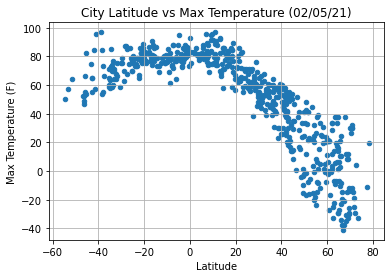

In [7]:
date= clean_city_data.Date.tolist()[0][0:8]
ax1 = clean_city_data.plot.scatter(x="Latitude", y="Max Temperature (F)")
ax1.set_title(f"City Latitude vs Max Temperature ({date})")
ax1.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Max_Temperature_Scatter_Plot.png")
plt.show()

## Latitude vs. Humidity Plot

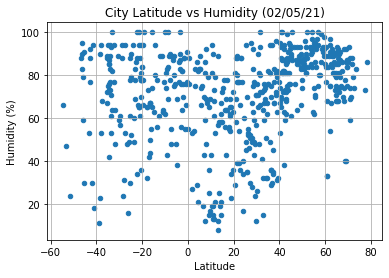

In [8]:
ax2 = clean_city_data.plot.scatter(x="Latitude", y="Humidity (%)")
ax2.set_title(f"City Latitude vs Humidity ({date})")
ax2.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Humidity_Scatter_Plot.png")
plt.show()

## Latitude vs. Cloudiness Plot

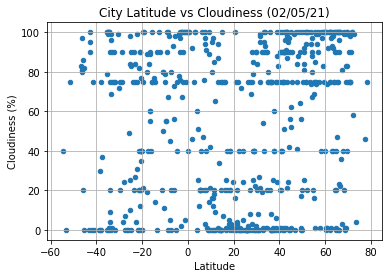

In [9]:
ax3 = clean_city_data.plot.scatter(x="Latitude", y="Cloudiness (%)")
ax3.set_title(f"City Latitude vs Cloudiness ({date})")
ax3.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Cloudiness_Scatter_Plot.png")
plt.show()

## Latitude vs. Wind Speed Plot

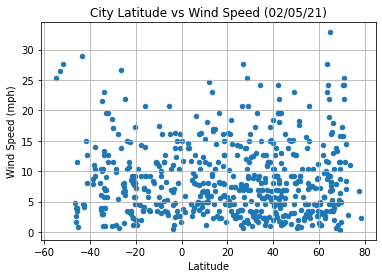

In [10]:
ax4 = clean_city_data.plot.scatter(x="Latitude", y="Wind Speed (mph)")
ax4.set_title(f"City Latitude vs Wind Speed ({date})")
ax4.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Wind_Speed_Scatter_Plot.png")
plt.show()

## Linear Regression

In [11]:
north_df = clean_city_data.loc[clean_city_data.Latitude>=0].reset_index()
n_lat = north_df.Latitude
north_df

,level_0,index,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,0,0,Isheyevka,54.4167,48.2667,32.00,100,90,15.66,RU,02/05/21 13:03
1,1,1,Marang,5.2056,103.2059,78.80,83,20,3.44,MY,02/05/21 13:07
2,2,2,Kadūr,13.5533,76.0131,68.34,58,34,2.33,IN,02/05/21 13:07
3,8,8,Tucupita,9.0622,-62.0510,83.79,65,89,6.60,VE,02/05/21 13:07
4,10,10,Nemuro,43.3236,145.5750,23.92,88,21,6.73,JP,02/05/21 13:02
...,...,...,...,...,...,...,...,...,...,...,...
399,573,573,Homer,59.6425,-151.5483,19.99,92,75,3.53,US,02/05/21 13:09
400,574,574,Severo-Yeniseyskiy,60.3725,93.0408,-1.98,93,100,7.23,RU,02/05/21 13:11
401,575,575,Vardø,70.3705,31.1107,26.60,93,90,24.16,NO,02/05/21 13:06
402,576,576,Nexø,55.0607,15.1306,26.60,74,75,4.61,DK,02/05/21 13:11


In [12]:
south_df = clean_city_data.loc[clean_city_data.Latitude<0].reset_index()
s_lat=south_df.Latitude
south_df

,level_0,index,City,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,3,3,Bambous Virieux,-20.3428,57.7575,80.60,78,40,8.05,MU,02/05/21 13:02
1,4,4,Busselton,-33.6500,115.3333,60.01,71,96,1.01,AU,02/05/21 13:03
2,5,5,Omboué,-1.5746,9.2618,79.65,88,100,7.99,GA,02/05/21 13:07
3,6,6,Carnarvon,-24.8667,113.6333,80.60,79,90,21.85,AU,02/05/21 13:05
4,7,7,Flinders,-34.5833,150.8552,73.00,85,100,3.00,AU,02/05/21 13:05
...,...,...,...,...,...,...,...,...,...,...,...
169,556,556,Vanimo,-2.6741,141.3028,78.55,82,100,4.81,PG,02/05/21 13:08
170,557,557,Realeza,-25.7689,-53.5325,79.00,49,49,6.53,BR,02/05/21 13:11
171,560,560,Talara,-4.5772,-81.2719,78.80,69,75,10.36,PE,02/05/21 13:11
172,564,564,Inhambane,-23.8650,35.3833,73.40,94,75,3.44,MZ,02/05/21 13:11


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7849911837977588


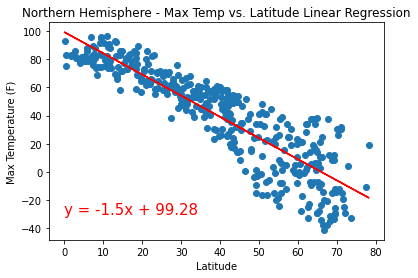

In [13]:
n_max_temp=north_df["Max Temperature (F)"]
(slope_nt, intercept_nt, rvalue_nt, pvalue_nt, stderr_nt) = linregress(n_lat, n_max_temp)
regress_values_nt = n_lat * slope_nt + intercept_nt
line_eq_nt = "y = " + str(round(slope_nt,2)) + "x + " + str(round(intercept_nt,2))
axnt=plt.scatter(n_lat,n_max_temp)
plt.plot(n_lat,regress_values_nt,"r-")
plt.annotate(line_eq_nt,(0,-30),fontsize=15,color="red")
plt.ylabel("Max Temperature (F)")
plt.xlabel('Latitude')
plt.title("Northern Hemisphere - Max Temp vs. Latitude Linear Regression")
plt.savefig(f"output_data/Northern_Hemisphere_Max_Temp_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_nt**2}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.31651681339438026


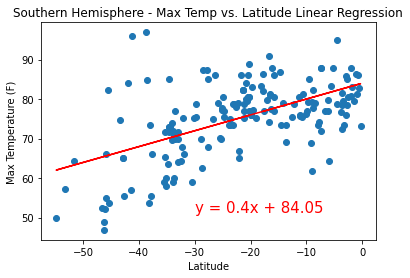

In [17]:
s_max_temp=south_df["Max Temperature (F)"]
(slope_st, intercept_st, rvalue_st, pvalue_st, stderr_st) = linregress(s_lat, s_max_temp)
regress_values_st = s_lat * slope_st + intercept_st
line_eq_st = "y = " + str(round(slope_st,2)) + "x + " + str(round(intercept_st,2))
axst=plt.scatter(s_lat,s_max_temp)
plt.plot(s_lat,regress_values_st,"r-")
plt.annotate(line_eq_st,(-30,51.5),fontsize=15,color="red")
plt.ylabel("Max Temperature (F)")
plt.xlabel('Latitude')
plt.title("Southern Hemisphere - Max Temp vs. Latitude Linear Regression")
plt.savefig(f"output_data/Southern_Hemisphere_Max_Temp_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_st**2}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.21911357734754075


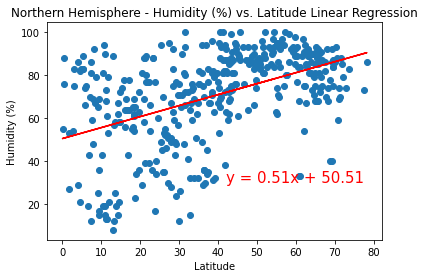

In [18]:
n_humidity=north_df["Humidity (%)"]
(slope_nh, intercept_nh, rvalue_nh, pvalue_nh, stderr_nh) = linregress(n_lat, n_humidity)
regress_values_nh = n_lat * slope_nh + intercept_nh
line_eq_nh = "y = " + str(round(slope_nh,2)) + "x + " + str(round(intercept_nh,2))
axnt=plt.scatter(n_lat,n_humidity)
plt.plot(n_lat,regress_values_nh,"r-")
plt.annotate(line_eq_nh,(42,30),fontsize=15,color="red")
plt.ylabel("Humidity (%)")
plt.xlabel('Latitude')
plt.title("Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression")
plt.savefig(f"output_data/Northern_Hemisphere_Humidity_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_nh**2}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.016778241976546704


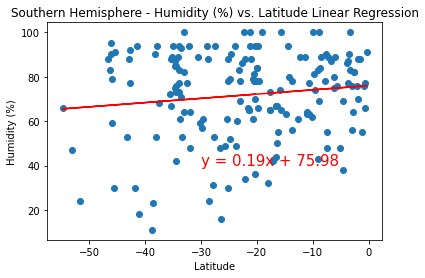

In [19]:
s_humidity=south_df["Humidity (%)"]
(slope_sh, intercept_sh, rvalue_sh, pvalue_sh, stderr_sh) = linregress(s_lat, s_humidity)
regress_values_sh = s_lat * slope_sh + intercept_sh
line_eq_sh = "y = " + str(round(slope_sh,2)) + "x + " + str(round(intercept_sh,2))
axnt=plt.scatter(s_lat,s_humidity)
plt.plot(s_lat,regress_values_sh,"r-")
plt.annotate(line_eq_sh,(-30,40),fontsize=15,color="red")
plt.ylabel("Humidity (%)")
plt.xlabel('Latitude')
plt.title("Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression")
plt.savefig(f"output_data/Southern_Hemisphere_Humidity_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_sh**2}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.09793171147102193


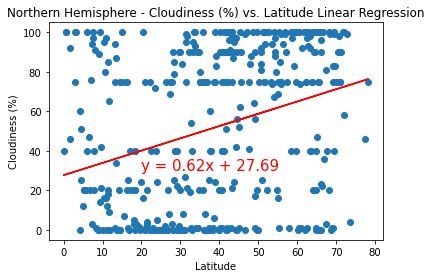

In [20]:
n_cloud=north_df["Cloudiness (%)"]
(slope_nc, intercept_nc, rvalue_nc, pvalue_nc, stderr_nc) = linregress(n_lat, n_cloud)
regress_values_nc = n_lat * slope_nc + intercept_nc
line_eq_nc = "y = " + str(round(slope_nc,2)) + "x + " + str(round(intercept_nc,2))
axnt=plt.scatter(n_lat,n_cloud)
plt.plot(n_lat,regress_values_nc,"r-")
plt.annotate(line_eq_nc,(20,30),fontsize=15,color="red")
plt.ylabel("Cloudiness (%)")
plt.xlabel('Latitude')
plt.title("Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression")
plt.savefig(f"output_data/Northern_Cloudiness_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_nc**2}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.029488479028660877


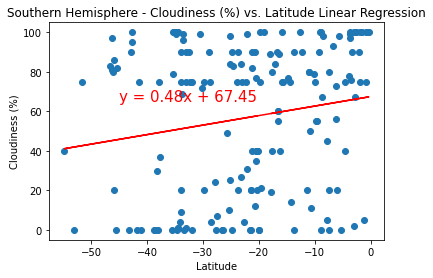

In [21]:
s_cloud=south_df["Cloudiness (%)"]
(slope_sc, intercept_sc, rvalue_sc, pvalue_sc, stderr_sc) = linregress(s_lat, s_cloud)
regress_values_sc = s_lat * slope_sc + intercept_sc
line_eq_sc = "y = " + str(round(slope_sc,2)) + "x + " + str(round(intercept_sc,2))
axnt=plt.scatter(s_lat,s_cloud)
plt.plot(s_lat,regress_values_sc,"r-")
plt.annotate(line_eq_sc,(-45,65),fontsize=15,color="red")
plt.ylabel("Cloudiness (%)")
plt.xlabel('Latitude')
plt.title("Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression")
plt.savefig(f"output_data/Southern_Cloudiness_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_sc**2}")
plt.show()


####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.00015930794609266677


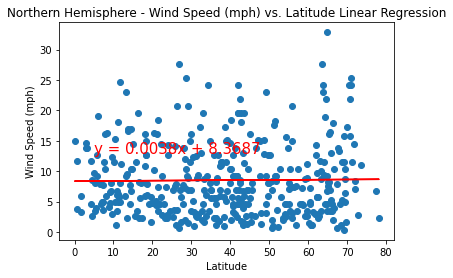

In [22]:
n_ws=north_df['Wind Speed (mph)']
(slope_ns, intercept_ns, rvalue_ns, pvalue_ns, stderr_ns) = linregress(n_lat, n_ws)
regress_values_ns = n_lat * slope_ns + intercept_ns
line_eq_ns = "y = " + str(round(slope_ns,4)) + "x + " + str(round(intercept_ns,4))
axnt=plt.scatter(n_lat,n_ws)
plt.plot(n_lat,regress_values_ns,"r-")
plt.annotate(line_eq_ns,(5,13),fontsize=15,color="red")
plt.ylabel("Wind Speed (mph)")
plt.xlabel('Latitude')
plt.title("Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression")
plt.savefig(f"output_data/Northern_Wind_Speed_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_ns**2}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.01914871067152192


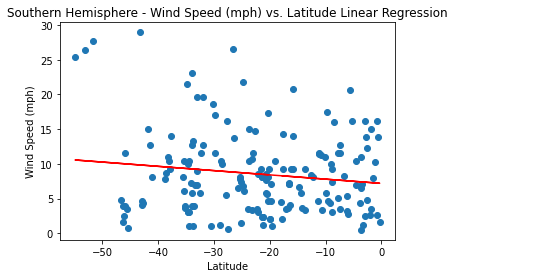

In [23]:
s_ws=south_df['Wind Speed (mph)']
(slope_ss, intercept_ss, rvalue_ss, pvalue_ss, stderr_ss) = linregress(s_lat, s_ws)
regress_values_ss = s_lat * slope_ss + intercept_ss
line_eq_ss = "y = " + str(round(slope_ss,2)) + "x + " + str(round(intercept_ss,2))
axnt=plt.scatter(s_lat,s_ws)
plt.plot(s_lat,regress_values_ss,"r-")
plt.annotate(line_eq_ss,(5,13),fontsize=15,color="red")
plt.ylabel("Wind Speed (mph)")
plt.xlabel('Latitude')
plt.title("Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression")
plt.savefig(f"output_data/Southern_Wind_Speed_vs_Latitude_Linear_Regression.png")
print(f"The r-squared is: {rvalue_ss**2}")
plt.show()